In [3]:
#DATA : http://archive.ics.uci.edu/ml/index.php
#Adult data set : http://archive.ics.uci.edu/ml/datasets/Adult
#초록 : 인구 조사 데이터를 기준으로 소득이 $ 50K / yr를 초과하는지 예측. "Census Income"데이터 세트
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
#plot에 print안해도됨
%matplotlib inline
#인풋아웃풋은 numpy
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from collections import Counter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.callbacks import Callback
from datetime import datetime, timezone


--2020-05-23 03:45:12--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  1.56MB/s    in 2.4s    

2020-05-23 03:45:15 (1.56 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [4]:
'''
age: continuous. 
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
fnlwgt: continuous. 
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
education-num: continuous. 
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
sex: Female, Male. 
capital-gain: continuous. 
capital-loss: continuous. 
hours-per-week: continuous. 
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
'''

'\nage: continuous. \nworkclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. \nfnlwgt: continuous. \neducation: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. \neducation-num: continuous. \nmarital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. \noccupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. \nrelationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. \nrace: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. \nsex: Female, Male. \ncapital-gain: continuous. \ncapital-loss: continuous. \nhours-per-week: continuous. \nnative-country: United-States,

** Data

In [5]:
#pandas는 테이블 형태로 정리해준다. 
cf = pd.read_csv('adult.data')
#no index
df = pd.read_csv('adult.data', index_col=False, names=['age', 'work', 'fniwgt', 'education', 'education-num', 'mari', 'occupation', 'relationship', 'race', 'sex', 'cg', 'cl', 'hw', 'na', '5k'])
df.head()
#cf.head()
df.count() #데이터 개수 확인
df.isnull().any() #데이터 null확인하고, 전처리한다. 

age              False
work             False
fniwgt           False
education        False
education-num    False
mari             False
occupation       False
relationship     False
race             False
sex              False
cg               False
cl               False
hw               False
na               False
5k               False
dtype: bool

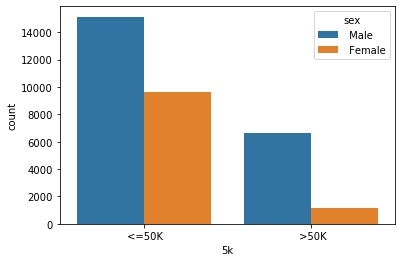

In [6]:
#데이터에서 소득의 비율 분포를 확인.
#seaborn으로 확인한다. 
#sns.countplot('5k',data=df) #Y target의 값의 비율(5k)이 좀 차이가 난다.
# 입력 feature 의 편중은 grid search같은 HPO에서 좋은 결과를 얻지 못한다. random search를 사용한다. 
sns.countplot('5k',hue='sex',data=df)

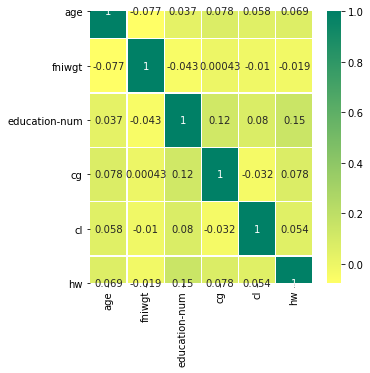

In [7]:
#숫자로 표현된 각 컬럼들의 서로의 상관도를 확인한다. 
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(),annot=True, cmap='summer_r', linewidths=0.2)

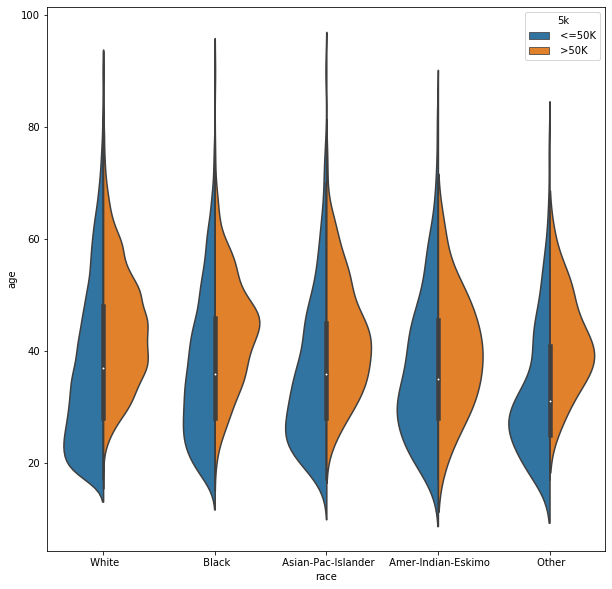

In [8]:
#인종별 나이에서 5k를 넘는지 확인 : 벨런스는 이상없음
plt.figure(figsize=(10,10))
sns.violinplot("race","age", hue="5k", data=df, split=True)

In [9]:
# Y target 정하기, one hot encode
# 5k 
Y = df['5k'].values.tolist()
#print(Y)
# 5k칼럼은 문자열로 NN에 적용할수 없으므로, 1: 5만불 이상, 0: 5만불 이하 
for i in range(len(Y)):
    if(Y[i] ==' <=50K'):
        Y[i] =1
    else:
        Y[i] =0

#Y = [1 if i==' <=50K' else 0 for i in Y]
Y = to_categorical(Y)
print(Y)


[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [10]:
X = df.drop(['age','fniwgt','education-num','cg','cl','hw','5k'], axis=1)
X = pd.get_dummies(X, drop_first=True)
X

,work_ Federal-gov,work_ Local-gov,work_ Never-worked,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,education_ 11th,education_ 12th,...,na_ Portugal,na_ Puerto-Rico,na_ Scotland,na_ South,na_ Taiwan,na_ Thailand,na_ Trinadad&Tobago,na_ United-States,na_ Vietnam,na_ Yugoslavia
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
df.head() 
#X의 정형데이터를 비정형으로 변환하고, One-hot encoding한다. 

#글자 칼럼과, 숫자 칼럼을 분리한다. 
#문자열만 남은 열(axis=1)을 X에 넣는다. (비정형 칼럼을 드롭)
X = df.drop(['age','fniwgt','education-num','cg','cl','hw','5k'], axis=1)
#문자열 feature를 숫자형으로 변환한다. 
X = pd.get_dummies(X, drop_first=True)

X = pd.concat([X,df[['age','fniwgt','education-num','cg','cl','hw']]], axis=1)

X.head() 
#데이터의 크기차이가 많이난다.

,work_ Federal-gov,work_ Local-gov,work_ Never-worked,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,education_ 11th,education_ 12th,...,na_ Trinadad&Tobago,na_ United-States,na_ Vietnam,na_ Yugoslavia,age,fniwgt,education-num,cg,cl,hw
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,39,77516,13,2174,0,40
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,50,83311,13,0,0,13
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,38,215646,9,0,0,40
3,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,53,234721,7,0,0,40
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,28,338409,13,0,0,40


In [12]:
# X feature들의 scale을 normalization한다. 
scaler = MinMaxScaler()
X[['age','fniwgt','education-num','cg','cl','hw']] = scaler.fit_transform(X[['age','fniwgt','education-num','cg','cl','hw']])
X.head()

,work_ Federal-gov,work_ Local-gov,work_ Never-worked,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,education_ 11th,education_ 12th,...,na_ Trinadad&Tobago,na_ United-States,na_ Vietnam,na_ Yugoslavia,age,fniwgt,education-num,cg,cl,hw
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0.452055,0.048238,0.800000,0.00000,0.0,0.122449
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0.287671,0.138113,0.533333,0.00000,0.0,0.397959
3,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0.493151,0.151068,0.400000,0.00000,0.0,0.397959
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.150685,0.221488,0.800000,0.00000,0.0,0.397959


In [13]:
#학습을 준비


In [14]:
#데이터 32561개 중 31561개는 TRAIN | 1천개는 TEST DATA로 분리한다. 
X_train = X[:-1000] 
X_test = X[-1000:]#뒤에서 천개 자르기 
Y_train = Y[:-1000] 
Y_test = Y[-1000:]#뒤에서 천개 자르기 

X_train.shape #X데이터 각각의 feature는 100개 


(31561, 100)

In [15]:
#모델작성
#class MetricHistory(Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        #local_time = datetime.now(timezone.utc).astimezone().isoformat()
#        print("\nEpoch {}".format(epoch + 1))
#        print("accuracy={:.4f}".format(logs['accuracy']))
#        print("loss={:.4f}".format(logs['loss']))
#        print("Validation-accuracy={:.4f}".format(logs['val_accuracy']))
#        print("Validation-loss={:.4f}".format(logs['val_loss']))
#history = MetricHistory()

In [16]:
import logging

# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.INFO)

# log 출력 형식
formatter = logging.Formatter('%(message)s')

# log 출력
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        local_time = datetime.now(timezone.utc).astimezone().isoformat()
        print("\nEpoch {}".format(epoch + 1))
        print("{} accuracy={:.4f}".format(local_time, logs['accuracy']))
        print("{} loss={:.4f}".format(local_time, logs['loss']))
        print("{} Validation-accuracy={:.4f}".format(local_time, logs['val_accuracy']))
        print("{} Validation-loss={:.4f}".format(local_time, logs['val_loss']))
        print("{} F1-score={:.4f}".format(local_time, logs['f1score']))
        print("{} recall={:.4f}".format(local_time, logs['recall']))
        print("{} precision={:.4f}".format(local_time, logs['precision']))
history = MetricHistory()

In [17]:
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from tensorflow.keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [18]:

model = Sequential()
model.add(Dense(1024, input_shape=(100,), activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()
###############################################################################

epochs =15
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) # accuracy값 계산  정답 확률 
###############################################################################
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy', precision, recall, f1score]) # accuracy값 계산  정답 확률 

# validation_split설정 fit
# X_train입력, Y_train을 주면 
# Validation설정, 모델이 한번 epochs학습을 끝내고 나면, 0.2 %의 데이터로 accuracy와 error를 계산한다.
hist = model.fit(X, Y, epochs=epochs, batch_size =100, validation_split=0.2, callbacks=[history])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 694,146
Trainable params: 694,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
250/261 [===========================>..] - ETA: 0s - loss: 0.4992 - accuracy: 0.7602 - precision: 0.7602 - recall: 0.7602 - f1score: 0.7602
Epoch 1
2020-05-23T03:45:24.462151+00:00 accuracy=0.7604
2020-05-23T03:45:24.462151+00:00 loss=0.

Epoch 11/15
254/261 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8390 - precision: 0.8390 - recall: 0.8390 - f1score: 0.8390
Epoch 11
2020-05-23T03:45:36.655131+00:00 accuracy=0.8385
2020-05-23T03:45:36.655131+00:00 loss=0.3437
2020-05-23T03:45:36.655131+00:00 Validation-accuracy=0.8380
2020-05-23T03:45:36.655131+00:00 Validation-loss=0.3437
2020-05-23T03:45:36.655131+00:00 F1-score=0.8386
2020-05-23T03:45:36.655131+00:00 recall=0.8386
2020-05-23T03:45:36.655131+00:00 precision=0.8386
261/261 [==============================] - 1s 5ms/step - loss: 0.3437 - accuracy: 0.8385 - precision: 0.8386 - recall: 0.8386 - f1score: 0.8386 - val_loss: 0.3437 - val_accuracy: 0.8380 - val_precision: 0.8361 - val_recall: 0.8361 - val_f1score: 0.8361
Epoch 12/15
253/261 [============================>.] - ETA: 0s - loss: 0.3406 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - f1score: 0.8406
Epoch 12
2020-05-23T03:45:37.885653+00:00 accuracy=0.8401
2020-05-23T03:45:37.

In [19]:
# model fit의 히스토리를 조회: 각각의 학습 값들이 배열로 저장됨
print(hist.history)

{'loss': [0.49625229835510254, 0.40639403462409973, 0.38145822286605835, 0.3710777759552002, 0.36444196105003357, 0.3593941628932953, 0.35540956258773804, 0.35217171907424927, 0.3487415313720703, 0.34589874744415283, 0.3436543345451355, 0.3415766656398773, 0.34004098176956177, 0.33821749687194824, 0.33648887276649475], 'accuracy': [0.7604038715362549, 0.8109259605407715, 0.827088475227356, 0.829161524772644, 0.8308123350143433, 0.8318873047828674, 0.8344210982322693, 0.8345362544059753, 0.8363022208213806, 0.8379146456718445, 0.8384904861450195, 0.840064525604248, 0.840525209903717, 0.8421759605407715, 0.842713475227356], 'precision': [0.7605904340744019, 0.8109291195869446, 0.8270593285560608, 0.8292528390884399, 0.830651581287384, 0.8320564031600952, 0.8343777060508728, 0.8344096541404724, 0.8362964987754822, 0.8378639221191406, 0.8385635018348694, 0.8401341438293457, 0.8407600522041321, 0.8421170711517334, 0.8426534533500671], 'recall': [0.7605904340744019, 0.8109291195869446, 0.827

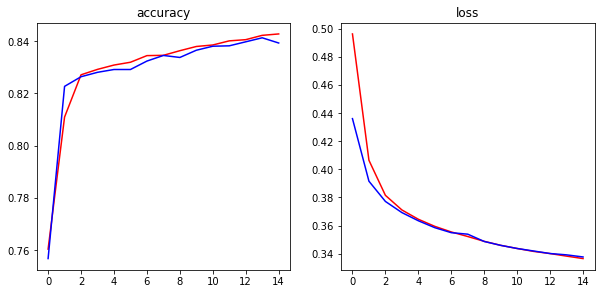

In [20]:
# accuracy 조회
# accuracy가 올라가고, validation_accuracy가 내려가는 오버피팅 구간이 있는지 확인한다. 
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(hist.history['accuracy'], color='r')
plt.plot(hist.history['val_accuracy'], color='b')
plt.title('accuracy')

#loss 조회
plt.subplot(2, 2, 2)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.title('loss')
plt.show()

In [21]:
# Evaluation 모델평가하기 : 0.8309999704360962 830건은 맞춤
score = model.evaluate(X_test, Y_test, batch_size=32)
#score = model.evaluate(X_test, Y_test)

print(score)

32/32 [==============================] - 0s 1ms/step - loss: 0.3568 - accuracy: 0.8170 - precision: 0.8154 - recall: 0.8154 - f1score: 0.8154
[0.35678336024284363, 0.8169999718666077, 0.8154296875, 0.8154296875, 0.8154296278953552]


In [22]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(X_test, Y_test, batch_size=30)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))


34/34 [==============================] - 0s 1ms/step - loss: 0.3568 - accuracy: 0.8170 - precision: 0.8167 - recall: 0.8167 - f1score: 0.8167
loss: 0.357, accuracy: 0.817, precision: 0.817, recall: 0.817, f1score: 0.817


In [23]:
# PREDICTION 예측하기  
pred = model.predict(X_test)

print(pred[:10])
print(Y[:10])

[[0.8137516  0.18624842]
 [0.04074833 0.9592517 ]
 [0.44167677 0.55832326]
 [0.04473091 0.95526916]
 [0.8326133  0.16738671]
 [0.01666003 0.98334   ]
 [0.01427293 0.985727  ]
 [0.00728282 0.99271715]
 [0.35969552 0.64030457]
 [0.01171658 0.9882834 ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
